In [38]:
'''
ECSE 556 Homework 1
Regression
Gian Favero
October 6th, 2023
'''

# Common imports
import numpy as np
from sklearn.preprocessing import StandardScaler

# Import feature and response data
feature = np.genfromtxt('Data/gdsc_expr_postCB.csv', delimiter=',')

response = np.genfromtxt('Data/gdsc_dr.csv', delimiter=',')
response = response[7,:] # Select the response vector for the 7th drug, Doxurubicin

# Remove all columns that have NaN values in the response vector
feature = feature[:,~np.isnan(response)]
response = response[~np.isnan(response)]

# Transpose the feature matrix and response vector
feature = feature[1:, :].T # Remove the first row (gene names) and transpose
response = response.T

# Scale the feature matrix
scaler = StandardScaler()
feature = scaler.fit_transform(feature)

# Regression

Regularization Analysis

In [39]:
from sklearn.linear_model import Lasso

# Define range of alpha values to test
alpha = [0.01, 0.1, 0.3, 0.5, 0.9]
num_features = []

# Perform Lasso regression for each alpha value
for val in alpha:
    lasso = Lasso(alpha=val)
    lasso.fit(feature, response)
    weights = lasso.coef_
    num_features.append(len(weights[weights != 0]))

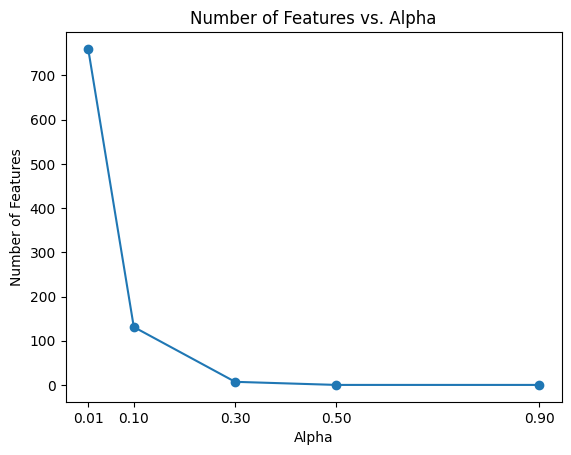

+------------------------------+
| Number of Features vs. Alpha |
+-------+----------------------+
| Alpha |  Number of Features  |
+-------+----------------------+
|  0.01 |         760          |
|  0.1  |         131          |
|  0.3  |          7           |
|  0.5  |          0           |
|  0.9  |          0           |
+-------+----------------------+


In [40]:
# Plot the number of features vs. alpha
import matplotlib.pyplot as plt
plt.scatter(alpha, num_features)
plt.plot(alpha, num_features)
plt.xlabel('Alpha')
plt.xticks(alpha)
plt.ylabel('Number of Features')
plt.title('Number of Features vs. Alpha')
plt.show()

# Make accompanying table
import prettytable as pt
table = pt.PrettyTable(['Alpha', 'Number of Features'])
for i in range(len(alpha)):
    table.add_row([alpha[i], num_features[i]])
table.title = 'Number of Features vs. Alpha'
print(table)

Nested Cross Validation

In [56]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import spearmanr

# Define inner and outer loop cross validation folds
inner_loop = KFold(n_splits=3)
outer_loop = KFold(n_splits=4)

# Define range of alpha values to test
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.9]}

# Initialize lists to store the performance metrics
MSEs = []
spearman_correlation = []
p_values = []
alpha = []
results = []

for train_idx, test_idx in outer_loop.split(feature):
    # Split the outer loop fold into training and testing sets
    x_train = feature[train_idx]
    x_test = feature[test_idx]
    y_train = response[train_idx]
    y_test = response[test_idx]

    # Perform the inner loop cross validation using a grid search
    hyper_tuning = GridSearchCV(estimator=Lasso(), param_grid=param_grid, cv=inner_loop)

    # Fit the tuned model on the training set
    hyper_tuning.fit(x_train, y_train) 
    hyper, optimal_model, cv_result = hyper_tuning.best_params_, hyper_tuning.best_estimator_, hyper_tuning.cv_results_

    # Evaluate the optimal model on the outer loop test set
    response_pred = optimal_model.predict(x_test)
    mse = np.mean((response_pred - y_test)**2)
    spearman, p = spearmanr(response_pred, y_test)

    # Store the performance metrics
    alpha.append(hyper['alpha'])
    results.append(cv_result)
    MSEs.append(mse)
    spearman_correlation.append(spearman)
    p_values.append(p)

# Make accompanying tables
import prettytable as pt

Fold_table = pt.PrettyTable(['Alpha', 'Mean Squared Error', 'Spearman Correlation', 'p-value'])

for i in range(len(MSEs)):
    Fold_table.add_row([alpha[i], MSEs[i].round(3), spearman_correlation[i].round(3), p_values[i].round(7)])

Fold_table.title = 'Model Performance Across Each Outer Loop Fold'

print(Fold_table)

Average_table = pt.PrettyTable(['Mean Squared Error', 'Spearman Correlation'])
Average_table.add_row([np.mean(MSEs).round(3), np.mean(spearman_correlation).round(3)])
Average_table.title = 'Average Model Performance'

print(Average_table)

+-------------------------------------------------------------+
|        Model Performance Across Each Outer Loop Fold        |
+-------+--------------------+----------------------+---------+
| Alpha | Mean Squared Error | Spearman Correlation | p-value |
+-------+--------------------+----------------------+---------+
|  0.1  |       2.308        |        0.323         | 1.1e-06 |
|  0.1  |       2.258        |        0.341         |  2e-07  |
|  0.1  |        2.93        |        0.317         | 1.8e-06 |
|  0.1  |       2.306        |        0.344         |  2e-07  |
+-------+--------------------+----------------------+---------+
+-------------------------------------------+
|         Average Model Performance         |
+--------------------+----------------------+
| Mean Squared Error | Spearman Correlation |
+--------------------+----------------------+
|       2.451        |        0.331         |
+--------------------+----------------------+


Baseline Models

In [65]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Mean of response vector
mean = np.mean(response)
baseline_mean = np.full((len(response), 1), mean)

# Median of response vector
median = np.median(response)
baseline_median = np.full((len(response), 1), median)

# Find MSE for each baseline model
MSE_mean = mean_squared_error(response, baseline_mean)
MSE_median = mean_squared_error(response, baseline_median)

# Find Spearman correlation for each baseline model
spearman_mean, p_mean = spearmanr(response, baseline_mean)
spearman_median, p_median = spearmanr(response, baseline_median)

# Make accompanying table
import prettytable as pt

baseline_table = pt.PrettyTable(['Model', 'Mean Squared Error', 'Spearman Correlation', 'p-value'])
baseline_table.add_row(['Mean', MSE_mean.__round__(3), spearman_mean.__round__(3), p_mean.__round__(7)])
baseline_table.add_row(['Median', MSE_median.__round__(3), spearman_median.__round__(3), p_median.__round__(7)])
baseline_table.title = 'Baseline Model Performances'
print(baseline_table)

+--------------------------------------------------------------+
|                 Baseline Model Performances                  |
+--------+--------------------+----------------------+---------+
| Model  | Mean Squared Error | Spearman Correlation | p-value |
+--------+--------------------+----------------------+---------+
|  Mean  |       2.777        |         nan          |   nan   |
| Median |       2.797        |         nan          |   nan   |
+--------+--------------------+----------------------+---------+
